<a href="https://colab.research.google.com/github/adampotton/MDM3-Rep-3/blob/main/logit_combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import files, drive
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


### Load everything

In [2]:
S2_logits = np.load('/content/drive/My Drive/Aerial Data/S2_99_logits.npy')
A_logits = np.load('/content/drive/My Drive/Aerial Data/aerial_99_logits.npy')

with open('/content/drive/My Drive/Aerial Data/Both Imagery/datapoints.json', 'r') as f:
    data = json.load(f)

A_logits = A_logits[[item[2] for item in data]]

true_labels = [item[1] for item in data]
unique_trees, true_labels_numeric = np.unique(true_labels, return_inverse=True)
number_to_tree = {i: species for i, species in enumerate(unique_trees)}

mapping = pd.read_csv('/content/drive/My Drive/S2 Data/tree_mapping.csv')
df = pd.DataFrame(mapping)

# Species Level (19 classes)

### Accuracies

In [ ]:
accuracy_S2 = np.mean(np.argmax(S2_logits, axis=1) == true_labels_numeric)
accuracy_A = np.mean(np.argmax(A_logits, axis=1) == true_labels_numeric)

print("Accuracy for S2 model: {:.5f}%".format(accuracy_S2*100))
print("Accuracy for Aerial model: {:.5f}%".format(accuracy_A*100))

Accuracy for S2 model: 75.55150%
Accuracy for Aerial model: 63.32137%


### True label class frequency

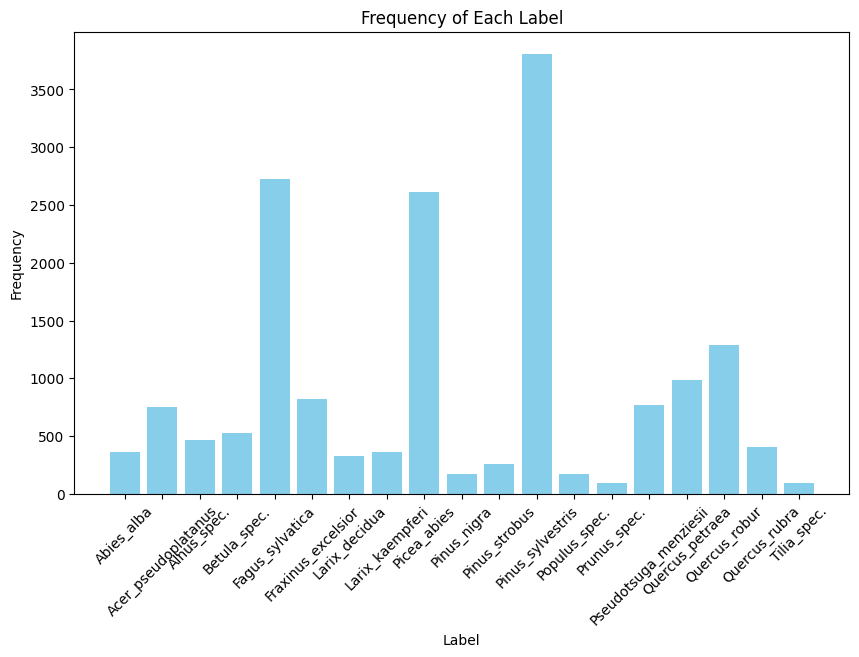

In [ ]:
unique_labels, label_counts = np.unique(true_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.title('Frequency of Each Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Combine logits with mean



In [ ]:
av_logits = (S2_logits + A_logits) / 2
av_predicted = np.argmax(av_logits, axis=1)
accuracy_av = np.mean(av_predicted == true_labels_numeric)
print("Mean logits accuracy: {:.5f}%".format(accuracy_av*100))

Mean logits accuracy: 75.84564%


### Combine logits with weighted mean

In [ ]:
weight_S2 = 0.7
weight_A = 1 - weight_S2

w_av_logits = (weight_S2 * S2_logits) + (weight_A * A_logits)
w_av_predicted = np.argmax(w_av_logits, axis=1)
accuracy_w_av = np.mean(w_av_predicted == true_labels_numeric)

print("Combined logits accuracy (weighted averaging): {:.6f}%".format(accuracy_w_av * 100))

Combined logits accuracy (weighted averaging): 79.028178%


# Hierarchical (all 4 classification types)

### Class mapping functions and getting predictions

In [9]:
def map_tree_name(name, classification):
    name = name.replace('_', ' ')
    row_number = df.index[df['Species'] == name][0]
    if classification == 0:
        return name
    elif classification == 1:
        return df.iloc[row_number, 1]
    elif classification == 2:
        return df.iloc[row_number, 2]
    elif classification == 3:
        return df.iloc[row_number, 3]

def apply_mapping(names, classification):
    return np.array([map_tree_name(name, classification) for name in names])

lab_14 = apply_mapping(true_labels,1)
lab_9 = apply_mapping(true_labels,2)
lab_2 = apply_mapping(true_labels,3)

true_labels_19 = true_labels_numeric
_, true_labels_14 = np.unique(lab_14, return_inverse=True)
_, true_labels_9 = np.unique(lab_9, return_inverse=True)
_, true_labels_2 = np.unique(lab_2, return_inverse=True)

S2_pred_19 = np.argmax(S2_logits, axis=1)
A_pred_19 = np.argmax(A_logits, axis=1)
_,S2_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],1), return_inverse=True)
_,A_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],1), return_inverse=True)
_,S2_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],2), return_inverse=True)
_,A_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],2), return_inverse=True)
_,S2_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(S2_logits, axis=1)],3), return_inverse=True)
_,A_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(A_logits, axis=1)],3), return_inverse=True)

av_logits = (S2_logits + A_logits) / 2
_,av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],0), return_inverse=True)
_,av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],1), return_inverse=True)
_,av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],2), return_inverse=True)
_,av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(av_logits, axis=1)],3), return_inverse=True)

w_av_logits = (0.8*S2_logits + 0.2*A_logits)
_,w_av_pred_19 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],0), return_inverse=True)
_,w_av_pred_14 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],1), return_inverse=True)
_,w_av_pred_9 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],2), return_inverse=True)
_,w_av_pred_2 = np.unique(apply_mapping([number_to_tree[num] for num in np.argmax(w_av_logits, axis=1)],3), return_inverse=True)

### Accuracies

In [14]:
accuracies = {
    "S2_19": np.mean(S2_pred_19 == true_labels_19),
    "A_19": np.mean(A_pred_19 == true_labels_19),
    "Average_19": np.mean(av_pred_19 == true_labels_19),
    "Weighted_Av_19": np.mean(w_av_pred_19 == true_labels_19),
    "S2_14": np.mean(S2_pred_14 == true_labels_14),
    "A_14": np.mean(A_pred_14 == true_labels_14),
    "Average_14": np.mean(av_pred_14 == true_labels_14),
    "Weighted_Av_14": np.mean(w_av_pred_14 == true_labels_14),
    "S2_9": np.mean(S2_pred_9 == true_labels_9),
    "A_9": np.mean(A_pred_9 == true_labels_9),
    "Average_9": np.mean(av_pred_9 == true_labels_9),
    "Weighted_Av_9": np.mean(w_av_pred_9 == true_labels_9),
    "S2_2": np.mean(S2_pred_2 == true_labels_2),
    "A_2": np.mean(A_pred_2 == true_labels_2),
    "Average_2": np.mean(av_pred_2 == true_labels_2),
    "Weighted_Av_2": np.mean(w_av_pred_2 == true_labels_2)
}

print("Model\t\t\tAccuracy")
print("-" * 33)
for model, accuracy in accuracies.items():
    print(f"{model}\t\t\t{accuracy * 100:.5f}%")



Model			Accuracy
---------------------------------
S2_19			75.55150%
A_19			63.32137%
Average_19			75.84564%
Weighted_Av_19			79.58115%
S2_14			79.80469%
A_14			66.85687%
Average_14			79.66351%
Weighted_Av_14			83.14018%
S2_9			81.98129%
A_9			68.29225%
Average_9			81.45773%
Weighted_Av_9			85.02853%
S2_2			96.70569%
A_2			91.99953%
Average_2			96.59980%
Weighted_Av_2			97.39985%


### Plot Bar Chart

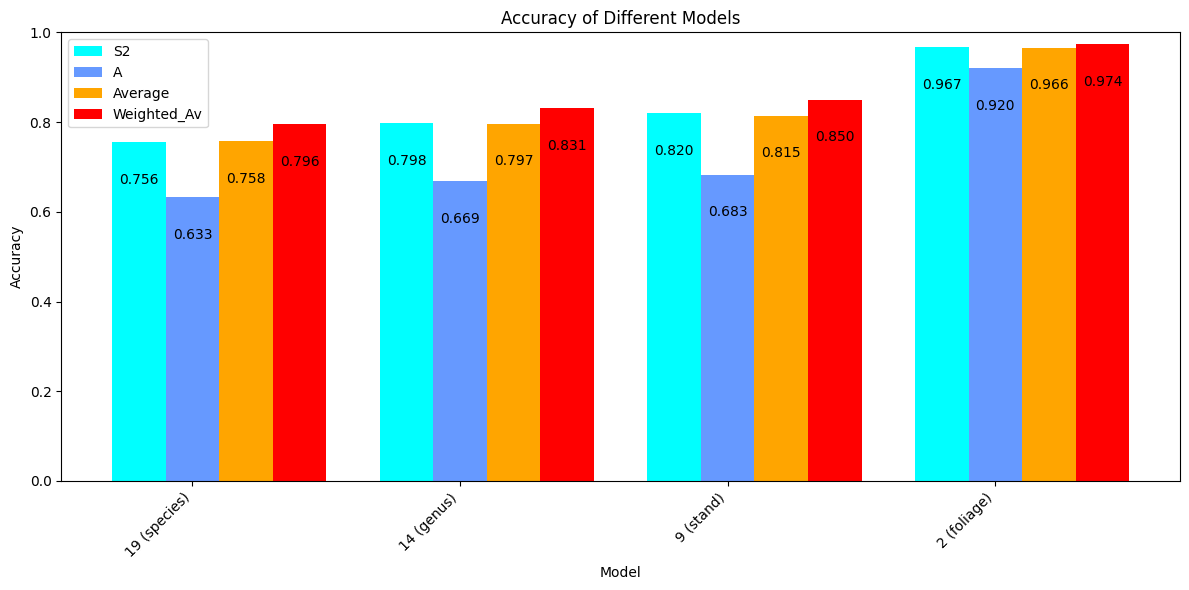

In [43]:
models = ["19 (species)", "14 (genus)", "9 (stand)", "2 (foliage)"]
accuracies_values = [accuracies[f"{model}_19"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_14"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_9"] for model in ["S2", "A", "Average", "Weighted_Av"]]
accuracies_values += [accuracies[f"{model}_2"] for model in ["S2", "A", "Average", "Weighted_Av"]]

x = np.arange(len(models))
bar_width = 0.2

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width, accuracies_values[::4], bar_width, label='S2', color='cyan')
bars2 = plt.bar(x, accuracies_values[1::4], bar_width, label='A', color='#6699FF')
bars3 = plt.bar(x + bar_width, accuracies_values[2::4], bar_width, label='Average', color='orange')
bars4 = plt.bar(x + 2 * bar_width, accuracies_values[3::4], bar_width, label='Weighted_Av', color='red')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.legend()

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, '{:.3f}'.format(bar.get_height()), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

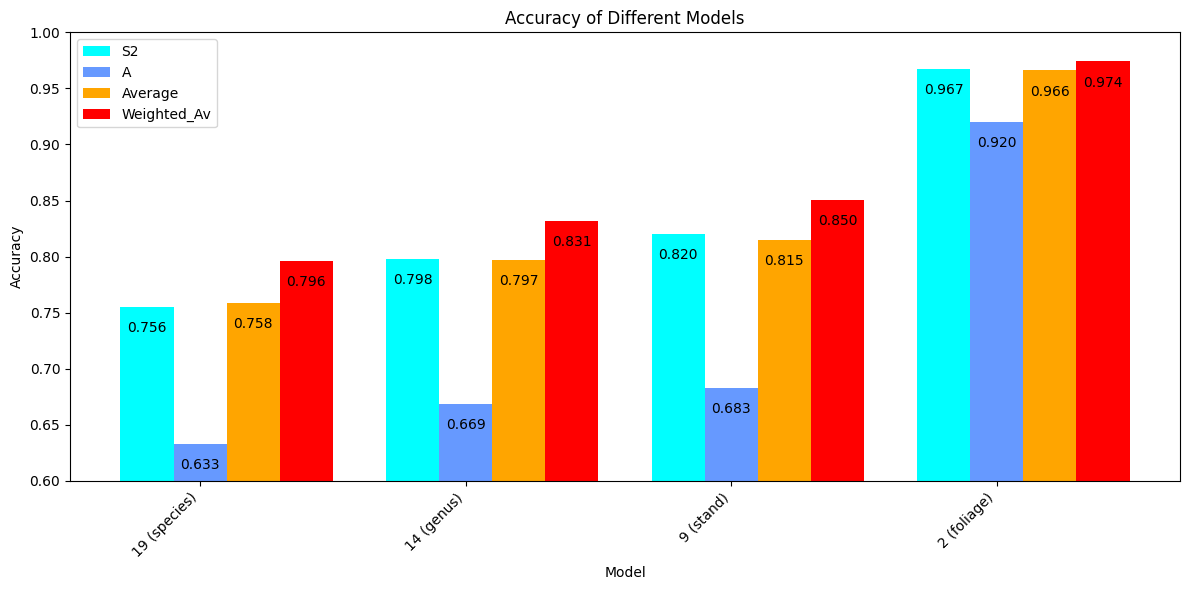

In [44]:
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width, accuracies_values[::4], bar_width, label='S2', color='cyan')
bars2 = plt.bar(x, accuracies_values[1::4], bar_width, label='A', color='#6699FF')
bars3 = plt.bar(x + bar_width, accuracies_values[2::4], bar_width, label='Average', color='orange')
bars4 = plt.bar(x + 2 * bar_width, accuracies_values[3::4], bar_width, label='Weighted_Av', color='red')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.6, 1)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.legend()

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.025, '{:.3f}'.format(bar.get_height()), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()